In [2]:
import sys
import os.path as op

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999
from sklearn.metrics import mean_squared_error as mse

from general.array import array_operations as aop
from general.basic.config import get_plot_defaults, set_rcparams
import general.basic.helper_funcs as hf
import general.basic.str_methods as strm

mpl.rcParams = set_rcparams(mpl.rcParams)
mpl.rcParams["axes.grid"] = False
d = get_plot_defaults()
co = d.get("colors", None)
colws = d.get("colws", None)
font = d.get("font", None)
lws = d.get("lws", None)
pad = d.get("pad", None)
palettes = d.get("palettes", None)

# Import data

In [20]:
# Import data
ssheet_dir = "/Users/dschonhaut/Box/projects/centiloid_calibration/ssheets"
data_ = pd.read_csv(op.join(ssheet_dir, "final_cohort_SUVR_w_CL_DS.csv"))
data = pd.read_csv(op.join(ssheet_dir, "bootstrap_CL_DS.csv"))
mean_yc = 1.013595674
mean_ad = 2.087774945
mean_diff = mean_ad - mean_yc

# Format columns
start_idx = data.columns.tolist().index("1")
data.columns = data.columns.tolist()[:start_idx] + [
    float(x) for x in data.columns.tolist()[start_idx:]
]
suvrs = np.asanyarray(data.columns.tolist()[start_idx:])

# Unpivot the dataframe to long format
data = data.melt(
    id_vars=["grp", "n_yc", "n_ad", "n_subjs", "bs"],
    value_vars=suvrs,
    var_name="suvr",
    value_name="cl",
)

# Format data types
data["grp"] = data["grp"].astype("category")
data["n_yc"] = data["n_yc"].astype(np.uint16)
data["n_ad"] = data["n_ad"].astype(np.uint16)
data["n_subjs"] = data["n_subjs"].astype(np.uint16)
data["bs"] = data["bs"].astype(np.uint16)
data["suvr"] = data["suvr"].astype(np.float32)
data["cl"] = data["cl"].astype(np.float32)

print(f"data_: {data_.shape}")
print(f"data: {data.shape}")

data_: (234, 6)
data: (16245000, 7)


In [21]:
OLS.fit(data_, "cl ~ suvr + grp", "bs", data, "cl ~ suvr + grp", "bs")

,lbl_id,suvr_nstd,suvr_std,dx,SUVR_estimated_from_LBL,CL_estimated
0,B09-270,1.1079,1.044095,YC,1.014383,0.072944
1,B10-201,1.1823,1.145541,YC,1.093650,7.456233
2,B10-202,1.0614,1.343800,YC,0.964841,-4.541612
3,B10-203,1.1055,1.111915,YC,1.011826,-0.165227
4,B10-204,1.1250,1.039650,YC,1.032602,1.769909
...,...,...,...,...,...,...
229,B19-263,1.8853,1.836431,AD,1.842638,77.220377
230,B19-266,2.3405,2.307235,AD,2.327616,122.393405
231,B19-285,2.2389,2.107694,AD,2.219369,112.310849
232,B19-288,1.4951,1.402519,AD,1.426912,38.497804


In [81]:
data_

,lbl_id,suvr_nstd,suvr_std,dx,SUVR_estimated_from_LBL,CL_estimated,cl_klunk,cl_daniel
0,B09-270,1.1079,1.044095,YC,1.014383,0.072944,-6.100476,3.800293
1,B10-201,1.1823,1.145541,YC,1.093650,7.456233,1.278509,10.822775
2,B10-202,1.0614,1.343800,YC,0.964841,-4.541612,-10.712341,-0.588759
3,B10-203,1.1055,1.111915,YC,1.011826,-0.165227,-6.338507,3.573761
4,B10-204,1.1250,1.039650,YC,1.032602,1.769909,-4.404499,5.414331
...,...,...,...,...,...,...,...,...
229,B19-263,1.8853,1.836431,AD,1.842638,77.220377,71.001976,77.177681
230,B19-266,2.3405,2.307235,AD,2.327616,122.393405,116.148665,120.143191
231,B19-285,2.2389,2.107694,AD,2.219369,112.310849,106.071987,110.553350
232,B19-288,1.4951,1.402519,AD,1.426912,38.497804,32.301980,40.347405


In [80]:
def convert_suvr_to_centiloid(
    lvl1_ssheet=None,
    lvl1_mean_suvr_cl_0=None,
    lvl1_mean_suvr_cl_100=None,
    lvl2_ssheet=None,
    save_output=True,
    output_dir=None,
    method="daniel",
):
    """Convert amyloid-PET SUVR values to Centiloids.

    Parameters
    ----------
    lvl1_ssheet : str, optional
        Full path to a spreadsheet (Excel or CSV file) containing data
        that will be used to reproduce the Level-1 analysis in an
        existing GAAIN Centiloid dataset. This spreadsheet is used to
        calculate the mean SUVR values in a group of subjects with
        negative amyloid status (the `CL-0` group, used to calibrate the
        0 Centiloid anchor) and in a group of subjects with positive
        amyloid status (the `CL-100` group, used to calibrate the 100
        Centiloid anchor). Alternatively, if these group mean SUVRs are
        already known, they can be directly provided by the
        `lvl1_mean_suvr_cl_0` and `lvl1_mean_suvr_cl_100` parameters, in
        which case `lvl1_ssheet` should not be passed. The first row of
        this spreadsheet must include the following column names, in any
        order (any other columns may be present but will be ignored):
        `id`        : Unique identifier for each subject (this column is
                      not strictly speaking needed but is a good idea to
                      include)
        `grp`       : Which group the scan is assigned to. Exactly two
                      groups must be present, one named `CL-0` (the
                      group used to calibrate the 0 Centiloid anchor),
                      and the other named `CL-100` (the group used to
                      calibrate the 100 Centiloid anchor)
        `suvr_gaain`: SUVR provided by GAAIN
        `cl_gaain`  : Centiloid provided by GAAIN
        `suvr_repr` : SUVR obtained by downloading the GAAIN dataset and
                      reproducing the Level-1 analysis steps
    lvl1_mean_suvr_cl_0 : float, optional
        Mean SUVR in the `CL-0` group, obtained by reproducing the
        Level-1 analysis in an existing GAAIN Centiloid dataset. This
        number will be used to calibrate the 0 Centiloid anchor.
        `lvl1_mean_suvr_cl_0` must be passed alongside
        `lvl1_mean_suvr_cl_100`, and either both of these parameters
        should be passed, or `lvl_ssheet` should be passed, but if all
        of these are passed the function will raise an error.
    lvl1_mean_suvr_cl_100 : float, optional
        Mean SUVR in the `CL-100` group, obtained by reproducing the
        Level-1 analysis in an existing GAAIN Centiloid dataset. This
        number will be used to calibrate the 100 Centiloid anchor.
    lvl2_ssheet : str, optional
        Full path to a spreadsheet (Excel or CSV file) containing site-
        acquired data that will be used to validate a new method or
        tracer for Centiloid conversion. The first row of this
        spreadsheet must include the following column names, in any
        order (any other columns may be present but will be ignored):
        `id`        : Unique identifier for each subject (this column is
                      not strictly speaking needed but is a good idea to
                      include)
        `suvr_std`  : SUVR obtained by reproducing the Level-1 analysis
                      steps (i.e. the Standard Method) in the new
                      dataset
        `suvr_nstd` : SUVR or other quantitative value (e.g. DVR)
                      obtained using a new amyloid-PET tracer or a new
                      (i.e. Non-Standard) analysis method
    method : str, optional
        Method used to calculate beta and gamma values. If 'daniel', a
        regression is fit with suvrs_std as the DV and suvrs_nstd as the
        IV. If 'klunk', a regression is fit with suvrs_nstd as the DV
        and suvrs_std as the IV. Default is 'daniel'.

    Returns
    -------

    """


def suvr_to_cl(suvrs_std, suvrs_nstd, mean_yc, mean_ad, method="daniel"):
    """Solve the Centiloid conversion eq. and convert SUVR_NStd to CL.

    Parameters
    ----------
    suvrs_std : array-like
        A vector of SUVR_Std values.
    suvrs_nstd : array-like
        A vector of SUVR_NStd values.
    mean_yc : float
        Mean SUVR in young controls from the GAAIN dataset, obtained by
        replicating the Level-1 analysis using the Standard Method
        (Klunk et al., 2015).
    mean_ad : float
        Mean SUVR in AD patients from the GAAIN dataset, obtained by
        replicating the Level-1 analysis using the Standard Method
        (Klunk et al., 2015).
    method : str, optional
        Method used to calculate beta and gamma values. If 'daniel', a
        regression is fit with suvrs_std as the DV and suvrs_nstd as the
        IV. If 'klunk', a regression is fit with suvrs_nstd as the DV
        and suvrs_std as the IV. Default is 'daniel'.

    Returns
    -------
    cls_nstd : array-like
        A vector of Centiloid values, converted from suvrs_nstd.
    cl_params : dict
        A dictionary containing the model r^2 along with beta and gamma
        values that can be used to convert SUVR_NStd to Centiloid values
        in new data.
    """
    # Calculate beta and gamma values for the SUVR_NStd to CL_Nstd conversion equation.
    cl_params = {}
    suvrs_std = np.asanyarray(suvrs_std).ravel()
    suvrs_nstd = np.asanyarray(suvrs_nstd).ravel()
    if method == "klunk":
        mod = sm.OLS(suvrs_nstd, sm.add_constant(suvrs_std)).fit()
        cl_params["theta"] = mod.params[0]  # icpt
        cl_params["lambda"] = mod.params[1]  # slope
        cl_params["beta"] = 100 / (cl_params["lambda"] * (mean_ad - mean_yc))
        cl_params["gamma"] = (-100 * (cl_params["theta"] + mean_yc)) / (
            cl_params["lambda"] * (mean_ad - mean_yc)
        )
    elif method == "daniel":
        mod = sm.OLS(suvrs_std, sm.add_constant(suvrs_nstd)).fit()
        cl_params["theta"] = mod.params[0]  # icpt
        cl_params["lambda"] = mod.params[1]  # slope
        cl_params["beta"] = (100 * cl_params["lambda"]) / (mean_ad - mean_yc)
        cl_params["gamma"] = (100 * (cl_params["theta"] - mean_yc)) / (
            mean_ad - mean_yc
        )
    else:
        raise ValueError(
            f"Method '{method}' not recognized. Must be 'klunk' or 'daniel'"
        )

    cl_params["rsquared"] = mod.rsquared

    # Calculate the CL_NStd values.
    cls_nstd = (cl_params["beta"] * suvrs_nstd) + cl_params["gamma"]

    return cls_nstd, cl_params

In [77]:
# Fit the gold-standard CL equation
# suvrs_std = data_["suvr_std"]
# suvrs_nstd = data_["suvr_nstd"]
# gs_mod_klunk = sm.OLS(data_["suvr_nstd"], data_[["suvr_std"]]).fit()
# gs_mod_daniel = sm.OLS(data_["suvr_std"], data_[["suvr_nstd"]]).fit()
# gs_icpt_klunk, gs_slope_klunk = gs_mod_klunk.params
# gs_icpt_daniel, gs_slope_daniel = gs_mod_daniel.params
cls_klunk, cl_params_klunk = suvr_to_cl(
    suvrs_std=data_["suvr_std"],
    suvrs_nstd=data_["suvr_nstd"],
    mean_yc=mean_yc,
    mean_ad=mean_ad,
    method="klunk",
)
cls_daniel, cl_params_daniel = suvr_to_cl(
    suvrs_std=data_["suvr_std"],
    suvrs_nstd=data_["suvr_nstd"],
    mean_yc=mean_yc,
    mean_ad=mean_ad,
    method="daniel",
)
data_["cl_klunk"] = cls_klunk
data_["cl_daniel"] = cls_daniel

In [79]:
data_.sort_values("suvr_nstd")

,lbl_id,suvr_nstd,suvr_std,dx,SUVR_estimated_from_LBL,CL_estimated,cl_klunk,cl_daniel
18,B13-308,0.99684,1.014369,YC,0.896058,-10.948402,-17.115395,-6.682461
13,B12-335,1.01360,0.959078,YC,0.913914,-9.285177,-15.453140,-5.100515
17,B13-305,1.01410,1.022499,YC,0.914447,-9.235558,-15.403550,-5.053321
11,B12-268,1.02280,0.929790,YC,0.923716,-8.372190,-14.540685,-4.232143
16,B13-247,1.02330,0.941762,YC,0.924249,-8.322571,-14.491095,-4.184949
...,...,...,...,...,...,...,...,...
118,B13-270,2.63860,2.623786,AD,2.645216,151.976181,145.714192,148.280314
209,B18-215,2.70860,2.664352,AD,2.719795,158.922824,152.656785,154.887488
186,B17-219,2.78170,2.747760,AD,2.797677,166.177104,159.906835,161.787266
168,B16-266,2.82840,2.619331,AD,2.847432,170.811508,164.538536,166.195195


In [18]:
# Calculate the median CL for each group and SUVR
data_med = data.groupby(["grp", "suvr"])["cl"].median().reset_index()
data_95ci = (
    data.groupby(["grp", "suvr"])["cl"]
    .apply(lambda x: np.abs(np.quantile(x, 0.975) - np.quantile(x, 0.025)))
    .reset_index()
)

/var/folders/c6/3jkgtnm96jqdyqv_gqr__hy00000gp/T/ipykernel_4475/1322717509.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_med = data.groupby(["grp", "suvr"])["cl"].median().reset_index()
/var/folders/c6/3jkgtnm96jqdyqv_gqr__hy00000gp/T/ipykernel_4475/1322717509.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_95ci = data.groupby(["grp", "suvr"])["cl"].apply(lambda x: np.abs(np.quantile(x, 0.975) - np.quantile(x, 0.025))).reset_index()


In [22]:
data_95ci

In [6]:
# Fit the gold-standard CL equation
xvals = data_med.query("(grp=='yc34ad200')")["suvr"]
yvals = data_med.query("(grp=='yc34ad200')")["cl"]
gs_mod = sm.OLS(yvals, sm.add_constant(xvals)).fit()
gs_icpt, gs_slope = gs_mod.params
data["cl_gs"] = data["suvr"].apply(lambda x: (x * gs_slope) + gs_icpt)
print(f"intercept: {gs_icpt:.2f}, slope: {gs_slope:.2f}")

# Add error vs. the gold-standard CLs.
data["cl_sqerr"] = (data["cl"] - data["cl_gs"]) ** 2

intercept: -100.77, slope: 94.39


In [10]:
data.query("(grp==['yc10ad15_klunk','yc10ad15'])")

,grp,n_yc,n_ad,n_subjs,bs,suvr,cl,cl_gs,cl_sqerr
0,yc10ad15,10,15,25,1,1.0,-6.296090,-6.382139,0.007404
1,yc10ad15,10,15,25,2,1.0,-4.461208,-6.382139,3.689976
2,yc10ad15,10,15,25,3,1.0,-3.738832,-6.382139,6.987073
3,yc10ad15,10,15,25,4,1.0,-6.688396,-6.382139,0.093794
4,yc10ad15,10,15,25,5,1.0,-8.331370,-6.382139,3.799503
...,...,...,...,...,...,...,...,...,...
16244995,yc10ad15_klunk,10,15,25,4996,2.7,151.990082,154.080310,4.369056
16244996,yc10ad15_klunk,10,15,25,4997,2.7,149.624191,154.080310,19.856998
16244997,yc10ad15_klunk,10,15,25,4998,2.7,146.179398,154.080310,62.424424
16244998,yc10ad15_klunk,10,15,25,4999,2.7,159.508804,154.080310,29.468546


In [104]:
cl_err = data.groupby(["grp", "suvr"])["cl_sqerr"].mean().reset_index()
cl_err.rename(columns={"cl_sqerr": "mse"}, inplace=True)
cl_err["rmse"] = np.sqrt(cl_err["mse"])

In [106]:
data.grp.cat.categories

Index(['nstd_suvr_quintiles', 'yc10ad100', 'yc10ad15', 'yc10ad15_klunk',
       'yc10ad200', 'yc10ad30', 'yc10ad50', 'yc10mci10ad5', 'yc20ad100',
       'yc20ad15', 'yc20ad200', 'yc20ad30', 'yc20ad50', 'yc30ad100',
       'yc30ad15', 'yc30ad200', 'yc30ad30', 'yc30ad50', 'yc34ad200'],
      dtype='object')

In [1]:
cl_err

NameError: name 'cl_err' is not defined

<Axes: xlabel='suvr', ylabel='rmse'>

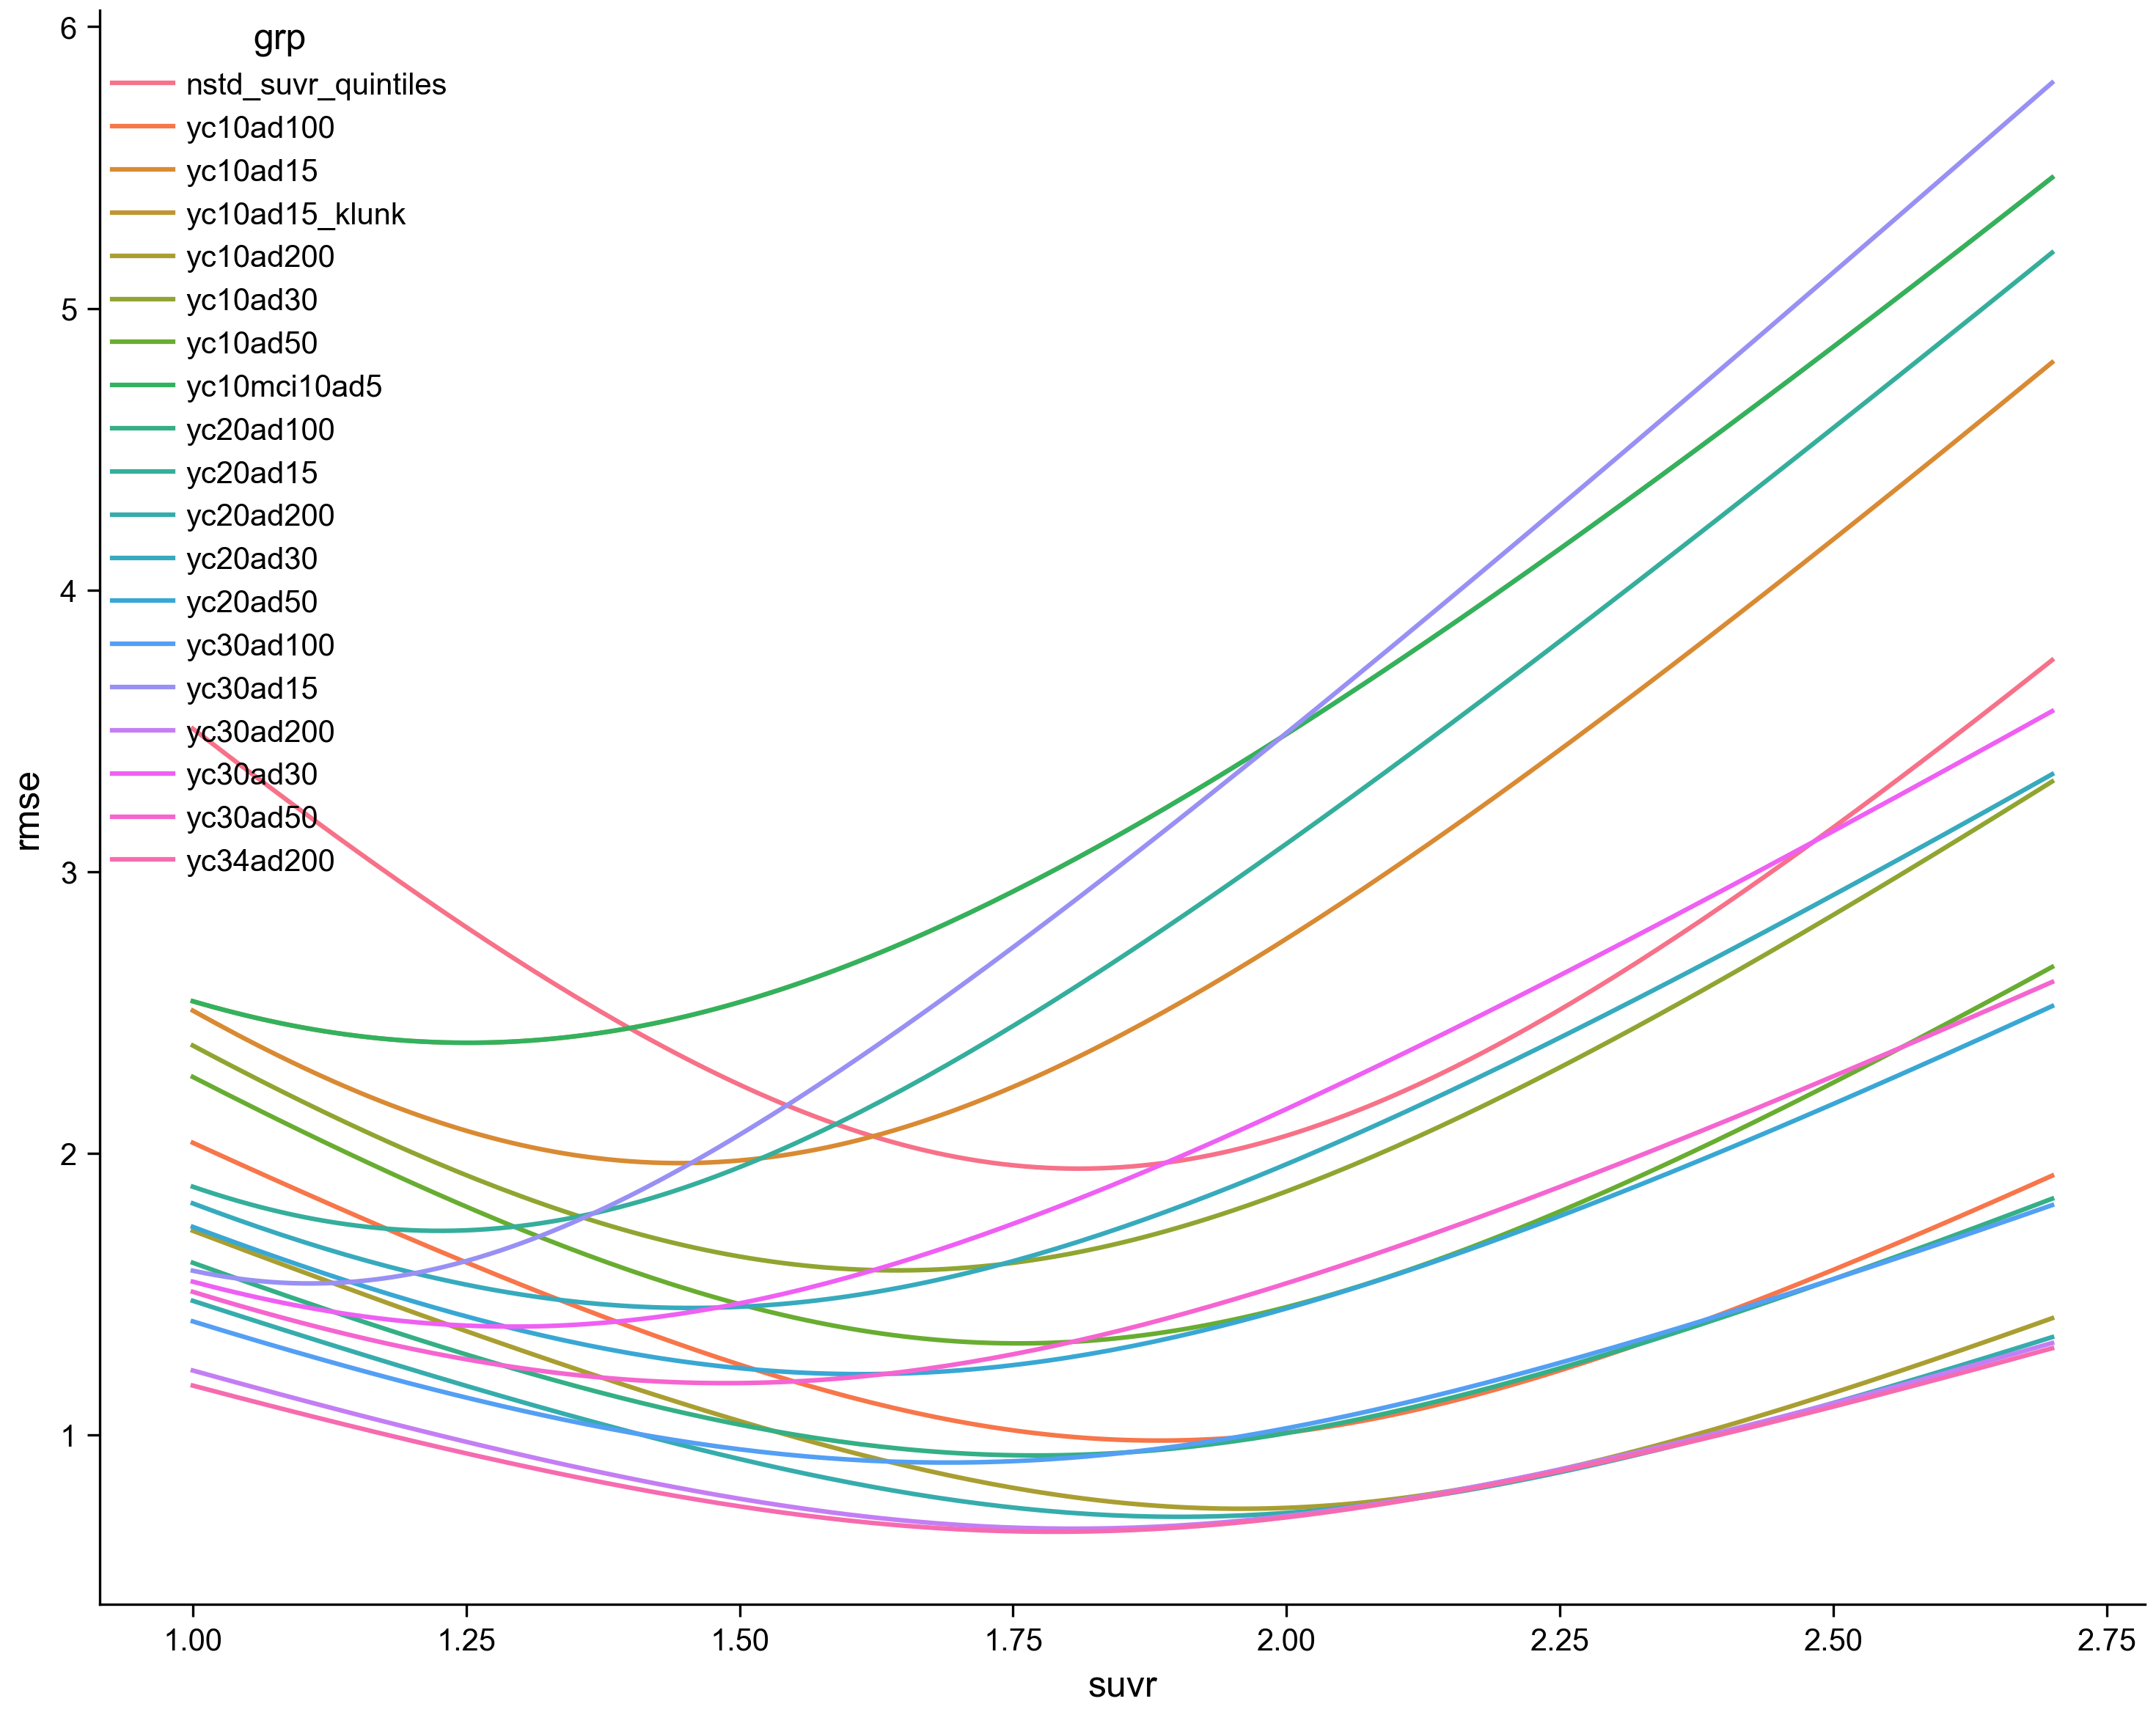

In [108]:
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
sns.lineplot(data=cl_err, x="suvr", y="rmse", hue="grp", ax=_ax)

In [49]:
data["grp"].cat.categories

Index(['nstd_suvr_quintiles', 'yc10ad100', 'yc10ad15', 'yc10ad15_klunk',
       'yc10ad200', 'yc10ad30', 'yc10ad50', 'yc10mci10ad5', 'yc20ad100',
       'yc20ad15', 'yc20ad200', 'yc20ad30', 'yc20ad50', 'yc30ad100',
       'yc30ad15', 'yc30ad200', 'yc30ad30', 'yc30ad50', 'yc34ad200'],
      dtype='object')

In [27]:
data.memory_usage()

Index          132
grp      129960000
n_yc     129960000
n_ad     129960000
suvr     129960000
cl       129960000
dtype: int64

In [14]:
start_idx = data.columns.tolist().index("1")
data.columns = data.columns.tolist()[:start_idx] + [
    float(x) for x in data.columns.tolist()[start_idx:]
]

In [18]:
suvr_rng = np.arange(1.0, 2.701, 0.01)

,grp,n_yc,n_ad,suvr,cl
0,yc10ad15,10,15,1.0,-6.296090
1,yc10ad15,10,15,1.0,-4.461208
2,yc10ad15,10,15,1.0,-3.738832
3,yc10ad15,10,15,1.0,-6.688396
4,yc10ad15,10,15,1.0,-8.331371
...,...,...,...,...,...
16244995,yc10ad15_klunk,10,15,2.7,151.990084
16244996,yc10ad15_klunk,10,15,2.7,149.624195
16244997,yc10ad15_klunk,10,15,2.7,146.179402
16244998,yc10ad15_klunk,10,15,2.7,159.508809


In [ ]:
data.rename(columns={drop(columns=["slope", "intercept"])